# Modeling Crop Yield
## Python modules

In [9]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date

import numpy as np
import pandas as pd
import geopandas
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [2]:
country_shp = geopandas.read_file(here('data', 'geo_boundaries', 'gadm36_ZMB_2.shp'))
country_shp = country_shp.set_index('district')

crop_df = pd.read_csv(here('data', 'crop_yield', 'cfs_maize_districts_zambia_2009_2022.csv'))
crop_df = crop_df.set_index(['district', 'year'])[['yield_mt']]
                             
weights_4_fn = 'ZMB_cropland_percentage_4k-points.feather'
weights_15_fn = 'ZMB_cropland_percentage_15k-points.feather'
weights_20_fn = 'ZMB_cropland_percentage_20k-points.feather'
  
weights_4 = pd.read_feather(here("data", "land_cover", weights_4_fn))
weights_15 = pd.read_feather(here("data", "land_cover", weights_15_fn))
weights_20 = pd.read_feather(here("data", "land_cover", weights_20_fn))
                           
weights_4.lon, weights_4.lat = round(weights_4.lon, 5), round(weights_4.lat, 5)
weights_15.lon, weights_15.lat = round(weights_15.lon, 5), round(weights_15.lat, 5)
weights_20.lon, weights_20.lat = round(weights_20.lon, 5), round(weights_20.lat, 5)

In [3]:
def get_merged_files(flist, **kwargs):
    return pd.concat([pd.read_feather(f, **kwargs) for f in flist], axis=0).reset_index(drop=True)

def merge_tuple(x, bases = (tuple, list)):
    for e in x:
        if type(e) in bases:
            for e in merge_tuple(e, bases):
                yield e
        else:
            yield e

In [4]:
file_groups = pd.DataFrame()
satellites = ["sentinel-2-l2a","landsat-8-c2-l2","landsat-c2-l2"]
for satellite in satellites:
    
    directory = here("data", "random_features", satellite)
    files = os.listdir(directory)
    files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
    files.sort()
    
    for file in files:
        f = file.split(sep="_")
        d = {
            'satellite'    : f[0],
            'bands'        : f[1].replace("bands-", ""),
            'country_code' : f[2],
            'points'       : int(f[3].replace("k-points", "")),
            'num_features' : f[4].replace("-features", ""),
            'pattern'      : f[0]+'_'+f[1]+'_'+f[2]+'_'+f[3]+'_'+f[4]+'_*'
        }
        df = pd.DataFrame(data=d, index=[0])
        file_groups = pd.concat([file_groups, df])
        
file_groups = file_groups.sort_values(by=['points'], ascending=True)
file_groups = file_groups.drop_duplicates().reset_index(drop=True)
file_groups

,satellite,bands,country_code,points,num_features,pattern
0,sentinel-2-l2a,2-3-4,ZMB,4,1000,sentinel-2-l2a_bands-2-3-4_ZMB_4k-points_1000-...
1,landsat-8-c2-l2,1-2-3-4-5-6-7,ZMB,15,1000,landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-po...
2,sentinel-2-l2a,2-3-4-8,ZMB,15,1000,sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_10...
3,sentinel-2-l2a,2-3-4,ZMB,15,1000,sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000...
4,landsat-c2-l2,r-g-b-nir-swir16-swir22,ZMB,20,1024,landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZM...
5,landsat-8-c2-l2,1-2-3-4-5-6-7,ZMB,20,1000,landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-po...
6,sentinel-2-l2a,2-3-4,ZMB,20,1000,sentinel-2-l2a_bands-2-3-4_ZMB_20k-points_1000...


In [5]:
file_groups = file_groups[file_groups.satellite == "landsat-8-c2-l2"]
file_groups = file_groups[file_groups.points == 20]
file_groups

,satellite,bands,country_code,points,num_features,pattern
5,landsat-8-c2-l2,1-2-3-4-5-6-7,ZMB,20,1000,landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-po...


In [6]:
names = 'limit_months crop_mask'.split()
paramlist = list(itertools.product([False,True], repeat = len(names)))
paramlist = list(itertools.product(file_groups.pattern.to_list(), paramlist))
for i in range(len(paramlist)):
    paramlist[i] = tuple(merge_tuple(paramlist[i]))
paramlist = [t for t in paramlist if (t[1] == True) & (t[2] == True)][0]
paramlist

('landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_*',
 True,
 True)

In [7]:
def impute_features(params):
    file         = params[0]
    limit_months = params[1]
    crop_mask    = params[2]
    # weighted_avg = params[3]
    f            = file.split(sep="_")
    satellite    = f[0]
    points       = int(f[3].replace("k-points", ""))
    num_features = int(f[4].replace("-features", ""))
 
    path = str(here("data", "random_features", satellite, file))
    files = glob.glob(pathname=path)
    
    print('Opening')
    
    features = get_merged_files(files)

    year_end = max(features.year)
    
    if satellite == "landsat-c2-l2":
        year_start = 2008
    elif satellite == "landsat-8-c2-l2":
        year_start = 2013 
    else:
        year_start = 2015 
        
    month_range = range(4, 10) if limit_months else range(1, 13)

    if (satellite == "landsat-8-c2-l2") & (limit_months):
        month_start = 4
    else:
        month_start = 10

    keep = np.where(
        ((features.year == year_start) & (features.month >= month_start)) | (features.year > year_start), True, False)

    features = features[keep]

    features['year'] = np.where(
        features['month'].isin([10, 11, 12]),
        features['year'] + 1, 
        features['year']
    )
    features = features[features.year <= year_end]

    features.lon, features.lat = round(features.lon, 5), round(features.lat, 5)

    features = features[features.month.isin(month_range)]

    features = features.set_index(['lon','lat', "year", 'month']).unstack()
    features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.reset_index(inplace = True)

    if points == 4:
        weights = weights_4.copy()
    elif points == 15:
        weights = weights_15.copy()
    elif points == 20:
        weights = weights_20.copy()

    features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])

    if crop_mask:
        features = features[features.crop_perc > 0]
    else:
        pass   

    features = geopandas.GeoDataFrame(
        features, 
        geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
        crs='EPSG:4326'
    )

    features = (
        features
        .sjoin(country_shp, how = 'left', predicate = 'within')
        .drop(['geometry'], axis = 1)
        .rename(columns = {"index_right": "district"})
        .dropna(subset=['district'])
        .reset_index(drop = True)
    )

    print('Imputing')
    
    num_cells = len(features) * len(month_range) * int(num_features)
    ln_ft = len(features); ln_na = len(features.dropna())
    features.fillna(features.groupby(['year', 'district'], as_index=False).transform('mean'), inplace=True)

    ln_ft = len(features); ln_na = len(features.dropna())
    features.fillna(features.groupby(['district'], as_index=False).transform('mean'), inplace=True)

    ln_ft = len(features); ln_na = len(features.dropna())
    features = features.dropna(axis=0)

    min_yr = min(features.year); max_yr = max(features.year)
    min_mn = min(month_range);   max_mn = max(month_range)

    f = f'{file[:-1]}yr-{min_yr}-{max_yr}_mn-{min_mn}-{max_mn}_lm-{limit_months}'+\
        f'_cm-{crop_mask}_full.feather'
    full_file = here('data', 'random_features', 'full_files', f)

    print('Saving')
    
    features.reset_index(drop=True).to_feather(full_file)

In [8]:
%%time
impute_features(paramlist)

Opening
Imputing
Saving
CPU times: user 7min 54s, sys: 3min 7s, total: 11min 2s
Wall time: 9min 25s


## Load the "best" model

In [81]:
hot_encode = True
weighted_avg = True
file_suffix = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True'
model_fn_suffix = f'{file_suffix}_wa-{weighted_avg}_he-{hot_encode}'

k_model_fn = f'k-fold-cv_rr-model_{model_fn_suffix}.pkl'
logo_model_fn = f'logo-cv_rr-model_{model_fn_suffix}.pkl'
       
with open(here('models', k_model_fn), 'rb') as f:
    best_kfold_model = pickle.load(f)

## Make high resolution predictions

In [82]:
high_res_f = f'{file_suffix}_full.feather'
high_res_fn = here('data', 'random_features', 'full_files', high_res_f)
high_res_features = pd.read_feather(high_res_fn)

drop_cols = ['year', 'lon', 'lat', 'crop_perc', 'district']

if weighted_avg:
    high_res_features = high_res_features.set_index(drop_cols)
    high_res_features.rename(columns={x:y for x,y in zip(high_res_features.columns,range(0,len(high_res_features.columns)))}, inplace=True)
    high_res_features = high_res_features.reset_index()
    high_res_features.columns = high_res_features.columns.astype(str)

if hot_encode:
    drop_cols.remove('district')
    high_res_features = pd.get_dummies(high_res_features, columns=["district"], drop_first=False)
else:
    pass

high_res_predictions = high_res_features.copy()[drop_cols]

high_res_x_all = high_res_features.drop(drop_cols, axis = 1) 
high_res_predictions['prediction'] = best_kfold_model.predict(high_res_x_all)

high_res_f_pred = f'high-res-pred_k-fold-cv_{model_fn_suffix}.feather'
high_res_fn_pred = here('data', 'results', high_res_f_pred)
high_res_predictions.to_feather(str(high_res_fn_pred))

## Make summary predictions

In [92]:
summary_f = f'{file_suffix}_wa-{weighted_avg}_summary.feather'
summary_fn = here('data', 'random_features', 'summary', summary_f)
summary_features = pd.read_feather(summary_fn)

In [93]:
drop_cols = ['district', 'year', 'yield_mt']
summary_predictions = summary_features.copy().loc[:, tuple(drop_cols)]

if hot_encode:
    drop_cols.remove("district")
    summary_features = pd.get_dummies(summary_features, columns=["district"], drop_first=False)
else:
    pass

summary_x_all = summary_features.drop(drop_cols, axis = 1) 
summary_y_all = np.log10(summary_features.yield_mt.to_numpy() + 1)
summary_predictions['log_yield'] = summary_y_all
summary_predictions['prediction'] = best_kfold_model.predict(summary_x_all)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(
    summary_x_all, summary_y_all, test_size = 0.2, random_state = 0)

In [95]:
kfold = KFold()
x_train['kfold_cv_predictions'] = cross_val_predict(best_kfold_model, X = x_train, y = y_train, cv=kfold)
x_train['split'], x_test['split']= 'train', 'test'
train_test = pd.concat([x_train, x_test])[['split', 'kfold_cv_predictions']]
summary_predictions = summary_predictions.join(train_test)

In [96]:
summary_f_pred = f'summary-pred_k-fold-cv_{model_fn_suffix}.feather'
summary_fn_pred = here('data', 'results', summary_f_pred)
summary_predictions.to_csv(summary_fn_pred, index=False)

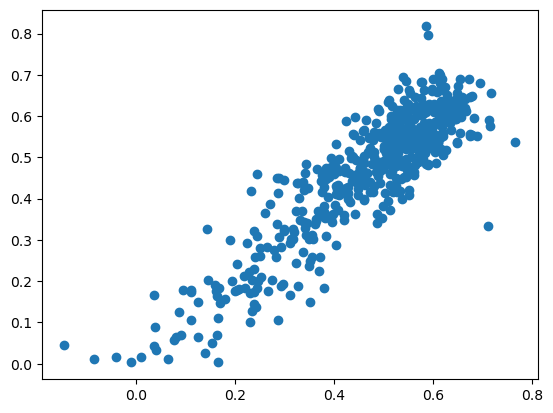

In [97]:
plt.scatter(x_train.kfold_cv_predictions, y_train)

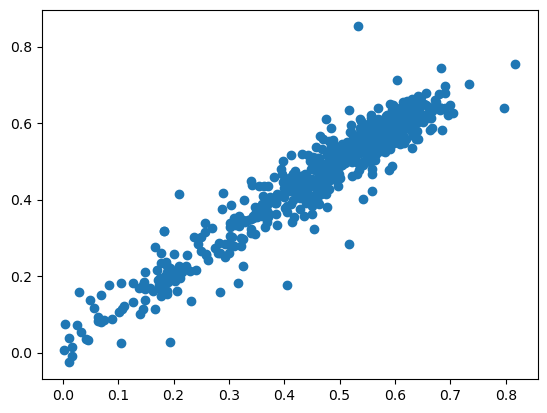

In [98]:
plt.scatter(summary_predictions.log_yield, summary_predictions.prediction)